# Libraries

In [1]:
import os  # For file and directory operations
import sys  # For system-specific parameters and functions

import cv2  # For image processing with OpenCV
import numpy as np  # For array operations with NumPy
import pandas as pd
import PIL.Image as Image  # For image handling with PIL
from IPython.display import display  # For displaying images in IPython
from tqdm import tqdm  # For progress bars

import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append("../")
from src.noises import add_noise  # Importing the add_noise function from the noises module

# 1. List images and pointers

In [2]:
PATH = "../../datasets/afw/"

pointers = {}

list_pointers = [x for x in os.listdir(PATH) if x.endswith('pts')]

for pointer in list_pointers:
    if((pointer[-6:] == '_1.pts') or (pointer[-6:] == '_2.pts')):
        pointers[str(pointer[:-6])] = {}

for pointer_name in tqdm(list_pointers):
    pointer_name_split = pointer_name.split('_')
    key = pointer_name_split[0]
    number = pointer_name_split[1].replace('.pts','')

    pointers[key][number] = f"{PATH}/{pointer_name}"

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 337/337 [00:00<00:00, 1188797.69it/s]


## 1.1 Images length

In [3]:
aux = []
for key in pointers.keys():
    aux.append(len(pointers[key]))

df_histogram = pd.Series(aux).value_counts().to_frame().reset_index()

df_histogram.rename({"index":"qtd_face"},axis=1,inplace=True)

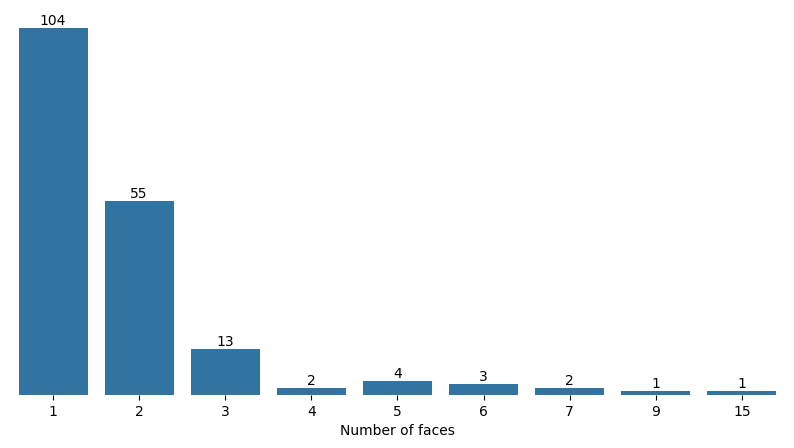

In [4]:
fig, ax = plt.subplots(figsize=(10,5))
bar = sns.barplot(data=df_histogram,x="qtd_face",y="count",ax=ax)

for container in bar.containers:
    ax.bar_label(container, fmt='%d')

ax.set_xlabel("Number of faces")
ax.set_ylabel("")
ax.set_yticks([])

ax.spines["top"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)

plt.show()

# 2. Visualization and plot

In [5]:
def visualize_afw_dataset(img_base, face_pointers, col=3, rescale_face_cropped=2.0, face_size=(224, 224, 3), draw_pointers=False):
    """
    Visualize the AFW dataset by cropping and displaying faces from the base image.

    Parameters:
    img_base (np.ndarray): Base image from which faces are cropped.
    face_pointers (dict): Dictionary with pointers to face landmark files.
    col (int): Number of columns in the final image.
    rescale_face_cropped (float): Scale factor for cropping around the face landmarks.
    face_size (tuple): Desired size of the output face images.
    draw_pointers (bool): Flag to draw landmarks on the base image.

    Returns:
    PIL.Image.Image: Image with all the cropped faces concatenated.
    """
    # Copy the base image to avoid modifying the original
    img = np.array(img_base.copy())
    
    # Determine the number of rows needed based on the total number of faces
    faces_total = len(face_pointers)
    if faces_total % col == 0:
        linhas = faces_total // col
    else:
        linhas = (faces_total // col) + 1
    
    # Initialize an array to hold the cropped face images
    faces = np.zeros((col * linhas, *face_size), np.uint8)
    
    # Iterate through each face pointer
    for i, sub_key in enumerate(face_pointers):
        landmark_pointer = []
        
        # Read the landmark points from the file
        with open(face_pointers[sub_key], 'r') as infile:
            # Skip the first three lines
            for _ in range(3):
                infile.readline()
        
            # Read the landmark points until the closing brace is found
            line = infile.readline().strip()
            while line != '}':
                landmark_pointer.append([int(float(x)) for x in line.split()])
                line = infile.readline().strip()
    
        # Optionally draw the landmark points on the image
        if draw_pointers:
            for x, y in landmark_pointer:
                cv2.circle(img, (x, y), 3, (0, 0, 255), -1)
        
        # Convert the landmark points to a NumPy array and calculate the bounding box
        aux_tranpose = np.array(landmark_pointer).T
        x_min, y_min = aux_tranpose[0].min(), aux_tranpose[1].min()
        x_max, y_max = aux_tranpose[0].max(), aux_tranpose[1].max()
        
        # Calculate the amount to expand the bounding box by the rescale factor
        var_x = int((x_max - x_min) * (rescale_face_cropped - 1) / 2)
        var_y = int((y_max - y_min) * (rescale_face_cropped - 1) / 2)
    
        # Crop the face from the image
        face_ = img[y_min - var_y:y_max + var_y, x_min - var_x:x_max + var_x].copy()
    
        # Resize the cropped face to the desired size
        face_ = cv2.resize(face_, face_size[:2])

        # Store the cropped face in the faces array
        faces[i] = face_
    
    # Concatenate the cropped faces into a grid
    aux = []
    for itr in range(1, linhas + 1):
        aux.append(np.concatenate(faces[col * (itr - 1):col * itr], axis=1))
    
    # Return the final image as a PIL image
    return Image.fromarray(np.concatenate(aux, axis=0))


## 2.1 Split faces and visualize

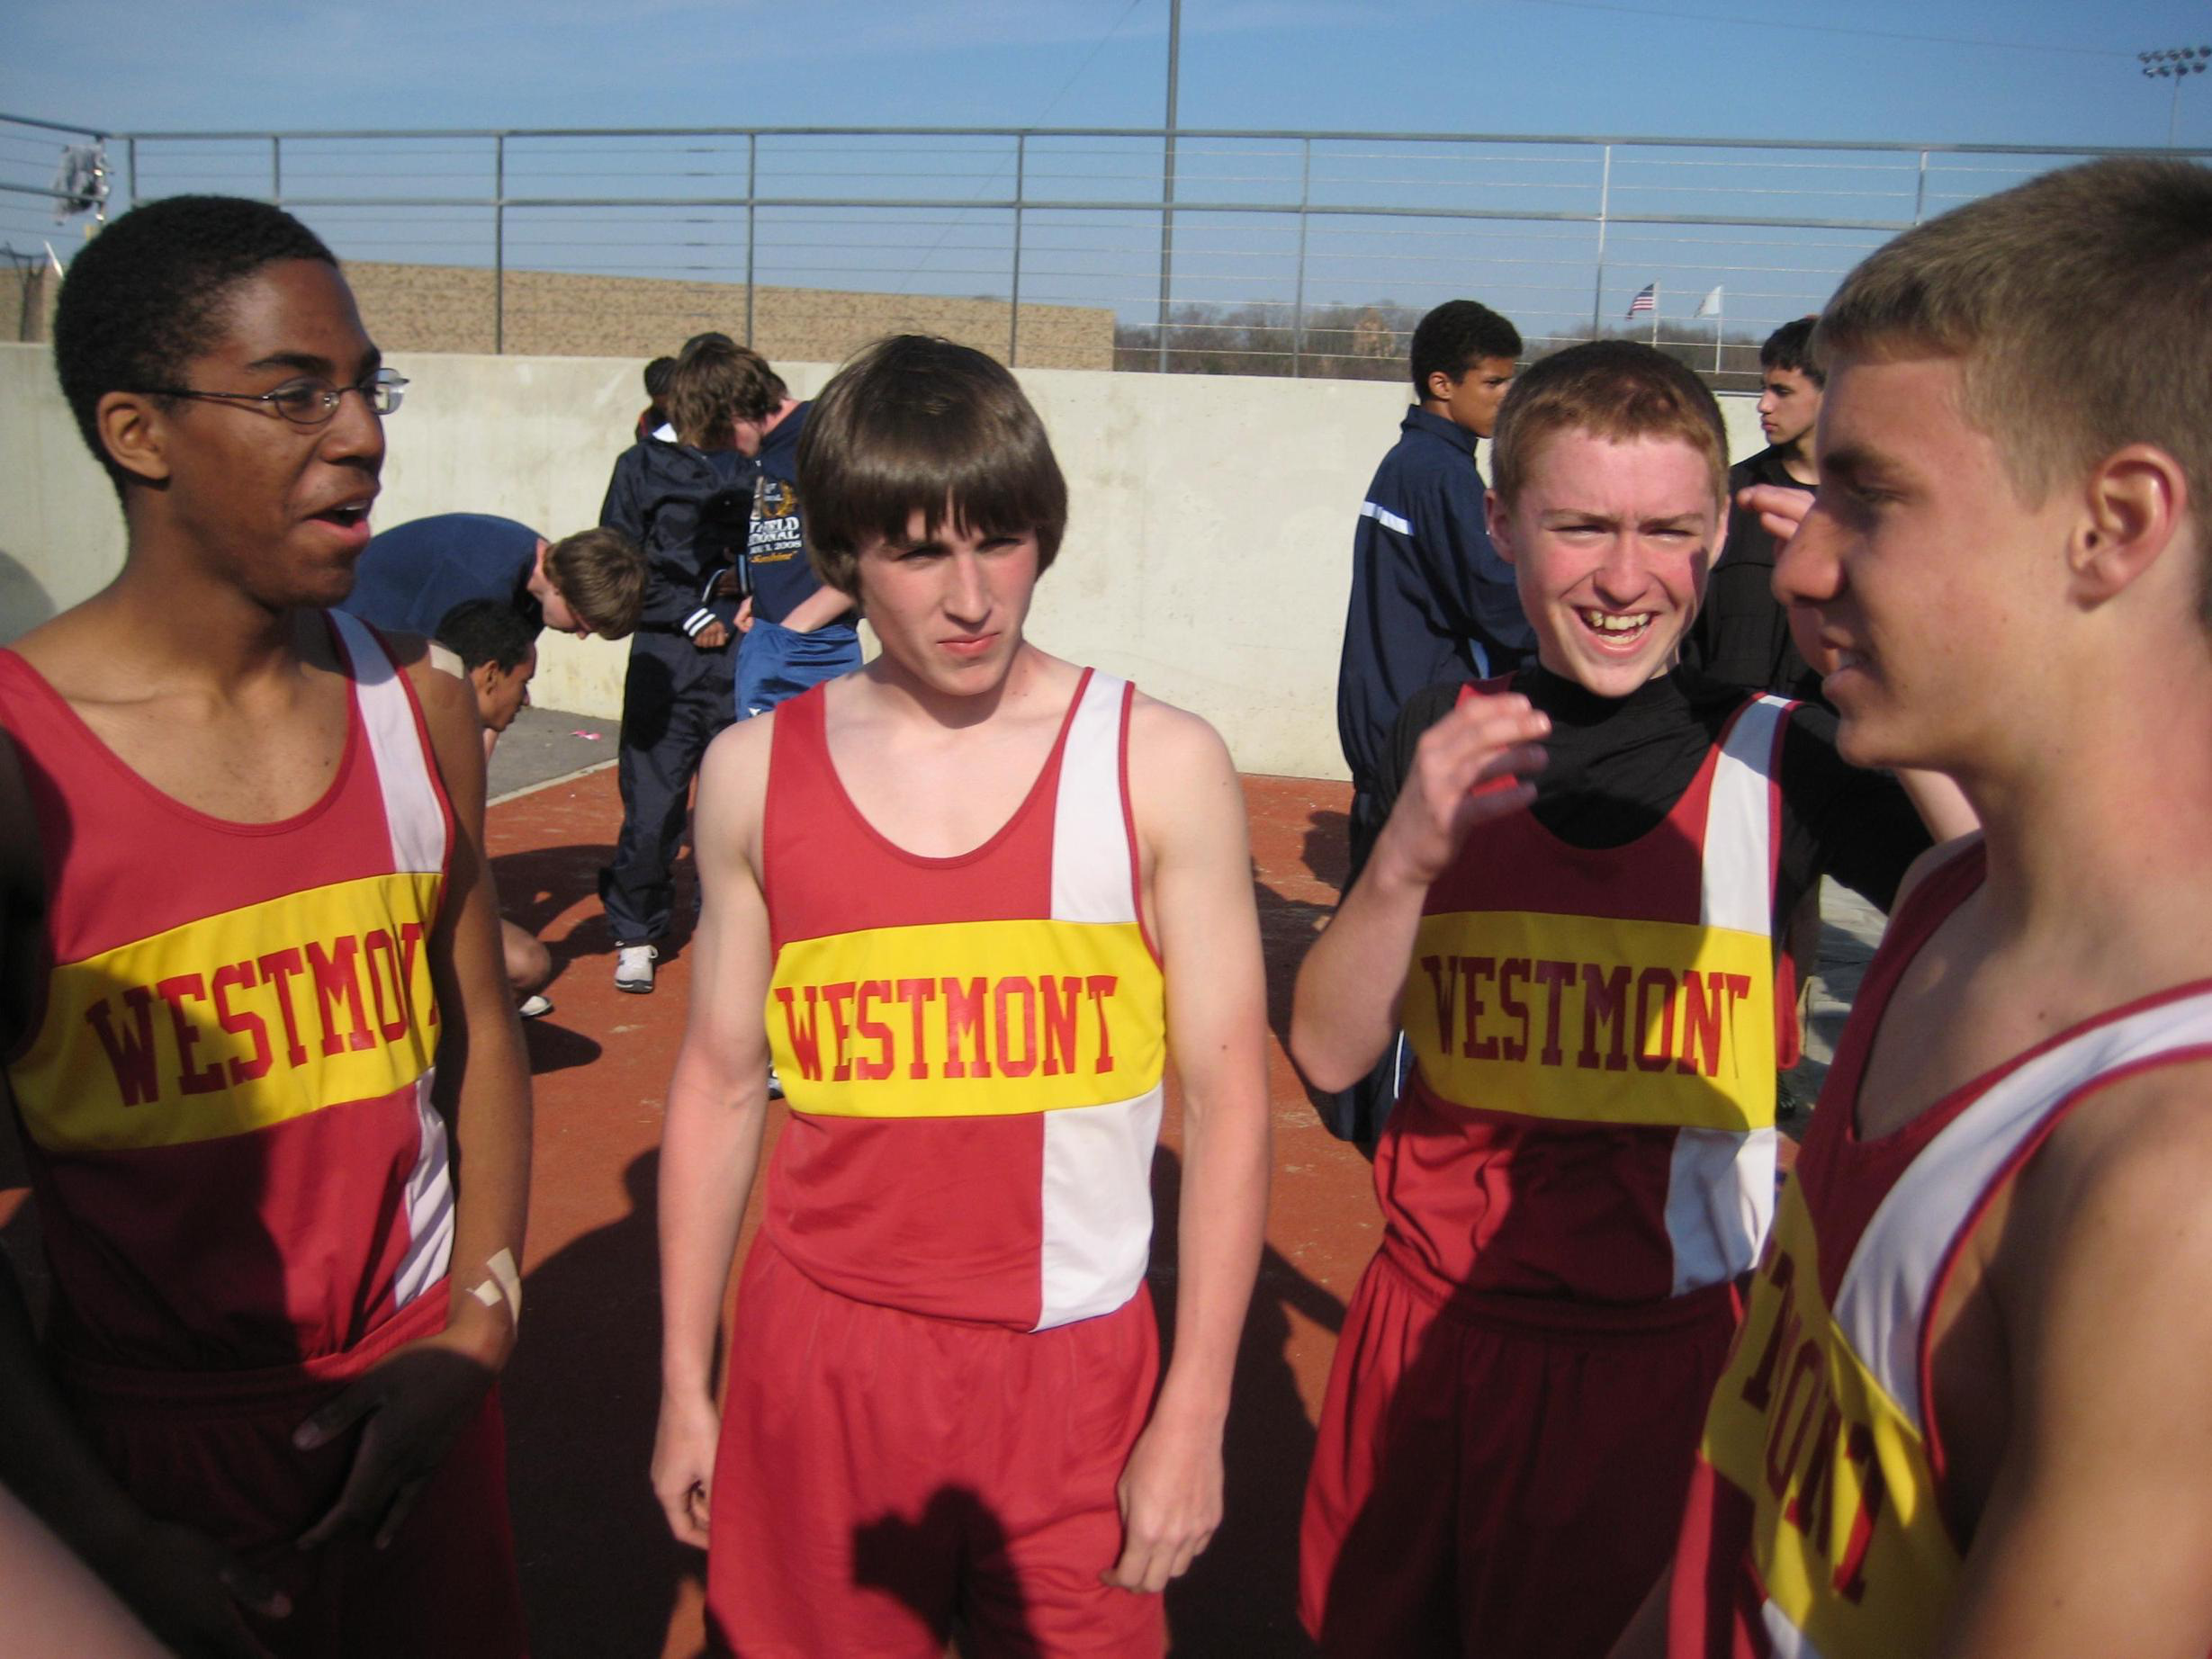

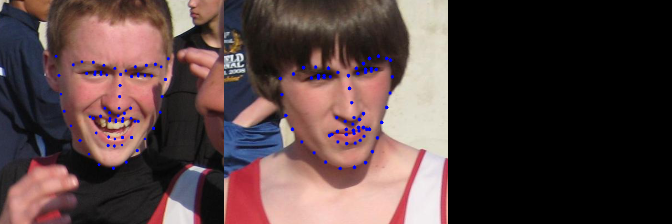

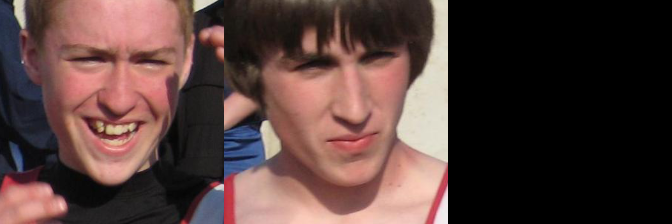

In [7]:
key = list(pointers.keys())[10]
img = Image.open(f'{PATH}/{key}_1.jpg').convert("RGB")

display(img)
display(visualize_afw_dataset(img,pointers[key],col=3,draw_pointers=True))
display(visualize_afw_dataset(img,pointers[key],col=3,draw_pointers=False,rescale_face_cropped=1.5))